In [ ]:
Using transfer learning , perform image classification of yoga poses.
Pretrained model : VGG19

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import cv2

Read in images with VGG19 preprocessing.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

vgg19_preprocess = tf.keras.applications.vgg19.preprocess_input
##
image_path = "../input/yoga-poses-cgi/train"
test_path = "../input/yoga-poses-cgi/test"
##

train_data_gen = ImageDataGenerator(preprocessing_function = vgg19_preprocess, validation_split = 0.2)
test_data_gen = ImageDataGenerator(preprocessing_function = vgg19_preprocess)


##
train_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'training' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')
val_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'validation' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

test_ds = test_data_gen.flow_from_directory(test_path ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


In [3]:
labels = (train_ds.class_indices)
labels_dict = dict((v,k) for k,v in labels.items())
labels_dict

{0: 'chair', 1: 'cobra', 2: 'dog', 3: 'tree', 4: 'warrior'}

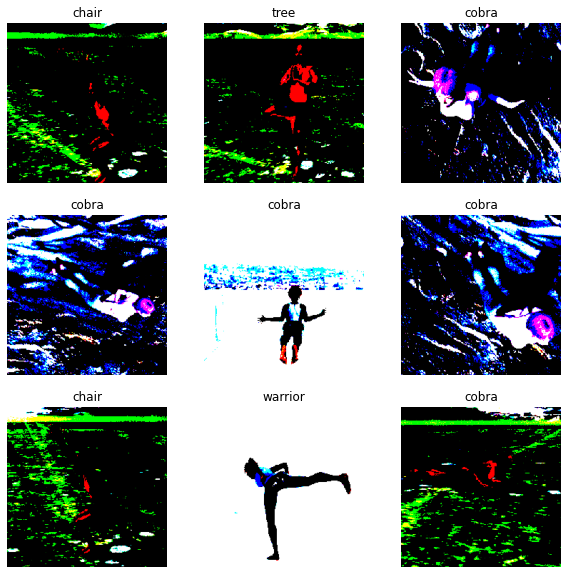

In [4]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")


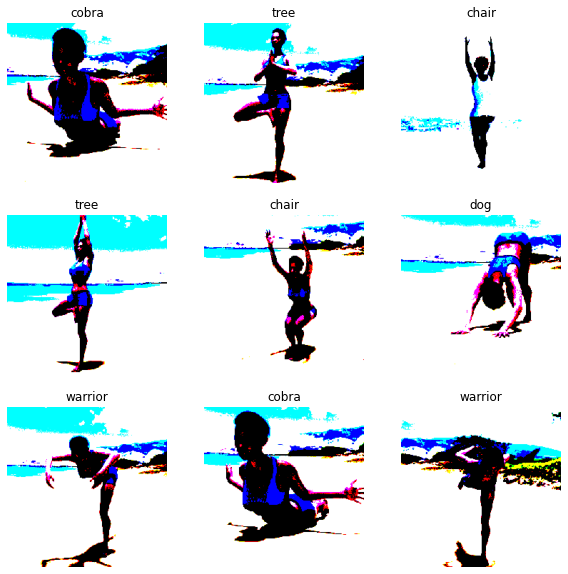

In [5]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

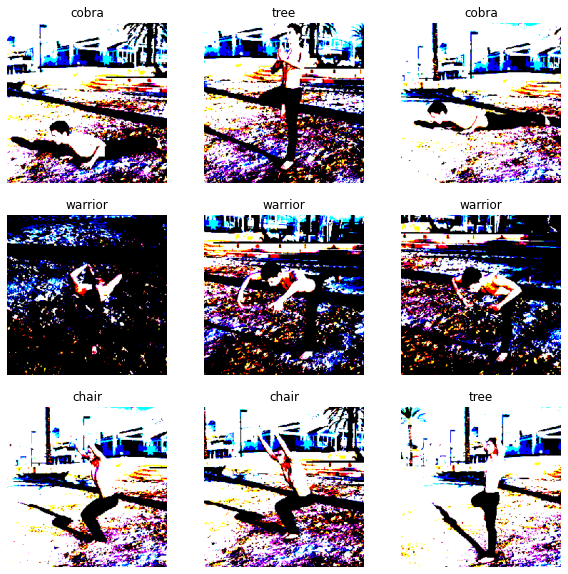

In [6]:
## visualize test images 
image_batch, label_batch = next(iter(test_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

2022-02-19 09:25:56.787509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 09:25:56.903505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 09:25:56.904787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 09:25:56.906583: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 20,554,821
Trainable params: 530,437
Non-trainable params: 20,024,384
_________________________________________________________________


2022-02-19 09:26:01.302999: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-19 09:26:03.660986: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


CPU times: user 4min, sys: 19.2 s, total: 4min 19s
Wall time: 4min 32s
25/25 [==============================] - 7s 293ms/step - loss: 0.7292 - accuracy: 0.8182
Test image accuracy :0.8181818127632141


2022-02-19 09:30:45.031491: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.97      0.46      0.62        81
       cobra       0.99      1.00      1.00       105
         dog       0.83      1.00      0.91        85
        tree       1.00      0.53      0.70        90
     warrior       0.60      0.99      0.75       102

    accuracy                           0.81       463
   macro avg       0.88      0.80      0.79       463
weighted avg       0.87      0.81      0.80       463



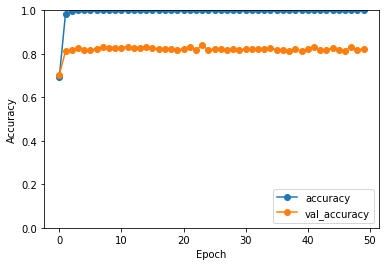

In [7]:
## Transfer learning with VGG19 . 
base_Net = tf.keras.applications.VGG19(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds , steps=STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_vgg19_1')

loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 20,554,821
Trainable params: 530,437
Non-trainable params: 20,024,384
_________________________________________________________________
CPU times: user 3min 56s, sys: 17.3 s, total: 4min 13s
Wall time: 4min 9s
25/25 [==============================] - 3s 107ms/step - loss: 0.0992 - accuracy: 0.9677
Test image accuracy :0.9676767587661743
Classification Report for new t

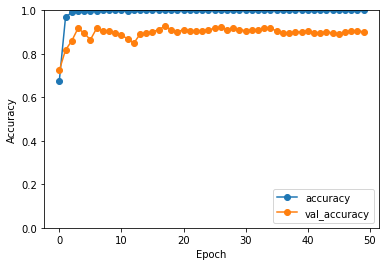

In [8]:
## Transfer learning with VGG19 . With drop out 
base_Net = tf.keras.applications.VGG19(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dropout(0.2))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds,  steps=STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_vgg19_2')

## for test data set , check the classification report.
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##
model_Net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 20,289,605
Trainable params: 265,221
Non-trainable params: 20,024,384
_________________________________________________________________
CPU times: user 3min 55s, sys: 17.6 s, total: 4min 13s
Wall time: 4min 9s
25/25 [==============================] - 3s 95ms/step - loss: 0.1612 - accuracy: 0.9475
Test image accuracy :0.9474747180938721
Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.79      0.97      0.88        79
       cobra

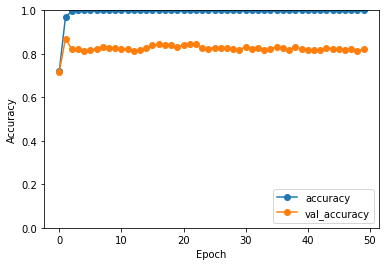

In [9]:
## Transfer learning with VGG19 . with 512 neurons
base_Net = tf.keras.applications.VGG19(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(512))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds, steps = STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_vgg19_3')

## for test data set , check the classification report.
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##
print(model_Net.summary())

#### Test model on new images of yoga pose. 

In [10]:
## read in all the new test yoga poses and check the prediction 

test_path_2 = "../input/new-yoga-poses/yoga_test_data"
test_ds_2 = test_data_gen.flow_from_directory(test_path_2 ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')


Found 26 images belonging to 5 classes.


In [11]:
## load the model 
model = tf.keras.models.load_model('./model_vgg19_3')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.33      0.33      0.33         6
       cobra       0.67      0.40      0.50         5
         dog       1.00      1.00      1.00         5
        tree       0.57      0.80      0.67         5
     warrior       0.80      0.80      0.80         5

    accuracy                           0.65        26
   macro avg       0.67      0.67      0.66        26
weighted avg       0.66      0.65      0.65        26



In [12]:
## load the model 
model = tf.keras.models.load_model('./model_vgg19_1')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.50      0.17      0.25         6
       cobra       0.75      0.60      0.67         5
         dog       1.00      0.80      0.89         5
        tree       0.62      1.00      0.77         5
     warrior       0.38      0.60      0.46         5

    accuracy                           0.62        26
   macro avg       0.65      0.63      0.61        26
weighted avg       0.64      0.62      0.59        26



In [13]:
## load the model 
model = tf.keras.models.load_model('./model_vgg19_2')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       0.75      0.50      0.60         6
       cobra       0.75      0.60      0.67         5
         dog       0.83      1.00      0.91         5
        tree       0.71      1.00      0.83         5
     warrior       0.60      0.60      0.60         5

    accuracy                           0.73        26
   macro avg       0.73      0.74      0.72        26
weighted avg       0.73      0.73      0.72        26



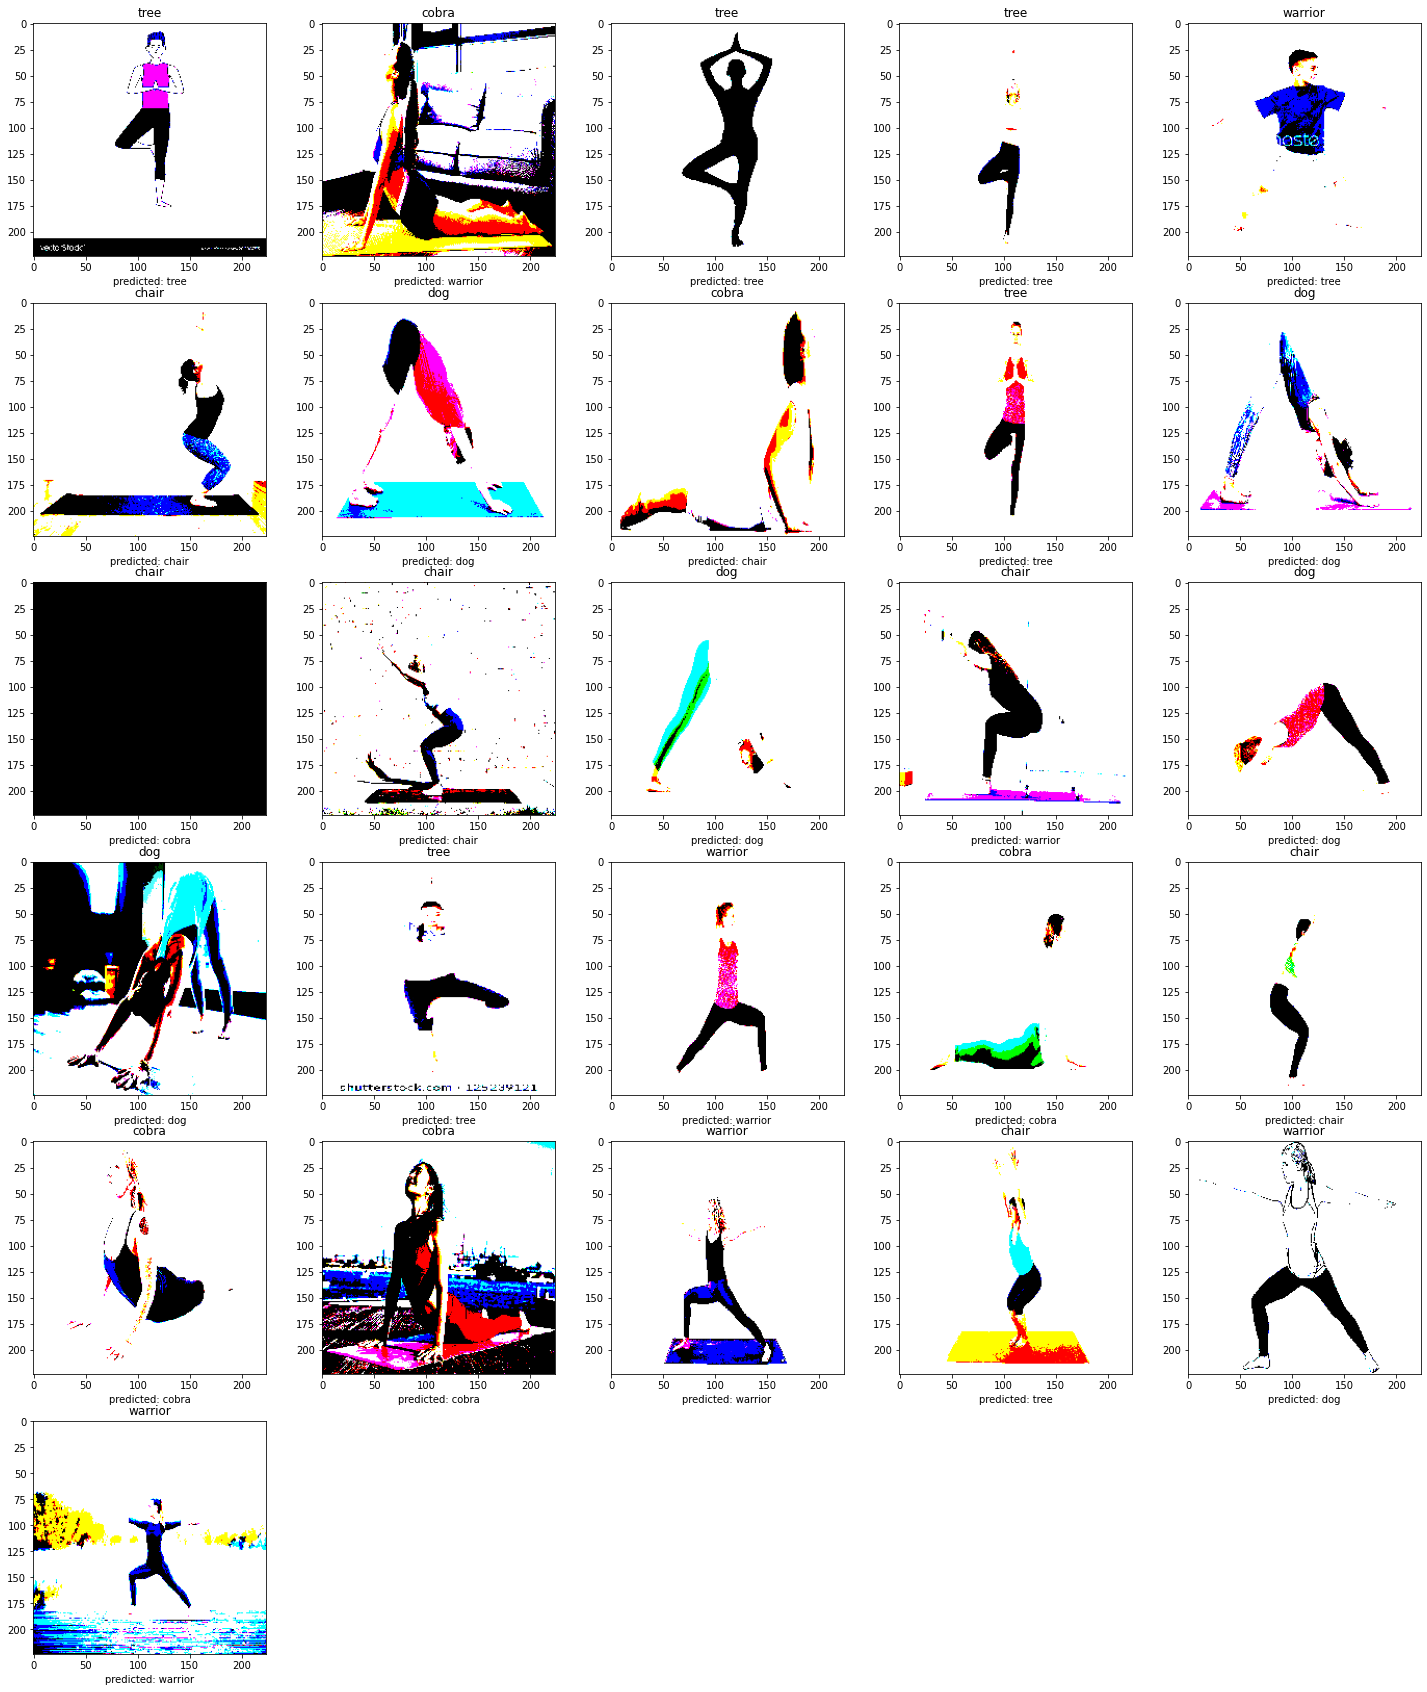

In [14]:
## visualize images with their prediction 

plt.figure(figsize=(25, 30))
for i in range(26):
    ax = plt.subplot(6, 5, i + 1)
    
    plt.imshow(cv2.cvtColor(img[0][i], cv2.COLOR_BGR2RGB))
    label = actual[i]
    pred_label = predicted[i]
    name = labels_dict[label]
    plt.title(name)
    plt.xlabel('predicted: ' + labels_dict[pred_label])
    #plt.axis("off")

Summary :

Transfer learning with ResNet50 gives best test image accuracy of 0.97. On the new images downloaded from the internet , which consists of non CGI origin , the accuracy is 0.73.